In [4]:
# Necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0
import matplotlib.pyplot as plt
import numpy as np

import os
import string
from PIL import Image
from collections import defaultdict

## Dataset Loading

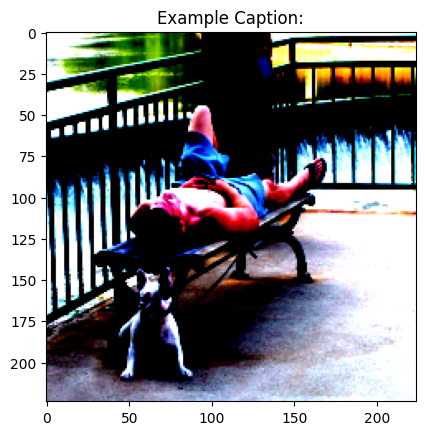

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # calculated based on the ImageNet dataset
])

images_path = "/kaggle/input/flickr8k"
captions_path = '/kaggle/input/flickr8k/captions.txt'

image_folder = ImageFolder(root=images_path, transform=transform)

captions = {}

with open(captions_path, 'r') as f:
    for line in f:
        line = line.strip()
        img_name, caption = line.split(',', maxsplit=1)
        img_name = img_name.split('#')[0]
        captions[img_name] = caption


example = 3
image, label = image_folder[example]  # Example image
plt.imshow(image.permute(1, 2, 0))  # Convert to HWC format for display
plt.title(f"Example Caption:")
plt.show()

## Dataset class and preprocessing

In [10]:
# text preprocessing and dataset creation
import re
from nltk.tokenize import word_tokenize
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import torch
from torch.utils.data import Dataset

class FlickrDataset(Dataset):
    def __init__(self, img_folder:str | ImageFolder, captions_file: str, transform=None, tokenizer = None, max_length = 50, threshold = 5):
        if isinstance(img_folder, str):
            img_folder = ImageFolder(root=img_folder, transform=transform)
                    
        self.img_folder = img_folder
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.threshold = threshold

        self.image_captions = self._load_captions(captions_file)

        self.vocab = self._build_vocab(self.image_captions, threshold = self.threshold)

        # mapping from image names to indices in the ImageFolder
        self.image_name_to_idx = {os.path.basename(path): idx for idx, (path, _) in enumerate(self.img_folder.imgs)}
    
    def _load_captions(self, captions_file):
        image_captions = []
        with open(captions_path, 'r') as f:
            for line in f:
                line = line.strip()
                img_name, caption = line.split(',', maxsplit=1)
                if img_name == 'image':
                    continue
                img_name = img_name.split('#')[0]
                image_captions.append((img_name, caption))
        
        return image_captions

    def _preprocess_caption(self, caption):
        """Preprocess the caption by tokenizing, removing punctuation, and lowercasing."""
        caption = caption.translate(str.maketrans('', '', string.punctuation))
        caption = caption.lower()
        
        if self.tokenizer:
            tokens = self.tokenizer(caption)
        else:
            tokens = caption.split()
            
        return tokens
    
    def _build_vocab(self, image_captions, threshold=5):
        """Build the vocabulary from the dataset captions."""
        from collections import Counter
        word_counts = Counter()

        # Count word frequencies from the captions
        for _, caption in image_captions:
            tokens = self._preprocess_caption(caption)
            word_counts.update(tokens)

        vocab = {
            '<PAD>': 0,  # Padding token
            '<SOS>': 1,  # Start of sequence token
            '<EOS>': 2,  # End of sequence token
            '<UNK>': 3   # Unknown word token
        }
        index = 4

        for word, count in word_counts.items():
            if count >= threshold:
                vocab[word] = index
                index += 1

        return vocab

    def _pad_caption(self, caption_seq, max_length):
        """Pads or truncates the caption sequence to a fixed length."""
        if len(caption_seq) < max_length:
            caption_seq += [self.vocab['<PAD>']] * (max_length - len(caption_seq))
        else:
            caption_seq = caption_seq[:max_length]
        return torch.tensor(caption_seq, dtype=torch.long)

        
    def __len__(self):
        return len(self.image_captions)
    
    def __getitem__(self, idx):
        img_name, caption = self.image_captions[idx]

        if img_name in self.image_name_to_idx:
            image_idx = self.image_name_to_idx[img_name]
            image, _ = self.img_folder[image_idx]  # Get image from ImageFolder
        else:
            raise FileNotFoundError(f"Image {img_name} not found in the image folder!")

        tokens = self._preprocess_caption(caption)

        tokenized_caption = [self.vocab.get('<SOS>')]  # Add <SOS> token
        tokenized_caption += [self.vocab.get(token, self.vocab.get('<UNK>')) for token in tokens]  # Convert words to indices
        tokenized_caption.append(self.vocab.get('<EOS>'))  # Add <EOS> token

        padded_caption = self._pad_caption(tokenized_caption, self.max_length)

        return image, padded_caption

## Model Definition

Model architecture:
* **Encoder**: extracting embeddings with **EfficinetNet** from the images
* **Decoder**: a transformer decoder which takes image embeddings as input and generate captions sequentially.
* **Attention Mechanism** : learning which part of image is important for caption generation (inherently used by the transformer block)

In [11]:
import timm

class Encoder(nn.Module):
    def __init__(self, encoding_size = 14):
        super(Encoder, self).__init__()
        self.encoder = timm.create_model('efficientnet_b0', pretrained=True)
        
        # removing classification layer
        self.encoder.classifier = nn.Identity()
        self.feature_dim = self.encoder.num_features
        
        self.pool = nn.AdaptiveAvgPool2d((encoding_size, encoding_size))
        
    def forward(self, images):
        features = self.encoder(images) # shape (batch, feature_dim)
        # print("Encoder output shape:", features.shape)
        if len(features.shape) == 4:
            features = self.pool(features)
        return features

In [12]:
class Decoder(nn.Module):
    def __init__(self, embedding_size, vocab_size, feature_dim, num_heads, num_layers, max_seq_len, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding_size = embedding_size
        self.max_seq_len = max_seq_len
        
        # embedding layer and positinal encoding
        self.embedding = nn.Embedding(vocab_size, self.embedding_size)
        self.pos_encoding = nn.Parameter(torch.randn(1, self.max_seq_len, self.embedding_size))
        
        self.image_proj = nn.Linear(feature_dim, self.embedding_size)
        
        # TODO: Use a comb. of TransformerDecoderLayer and TransformerDecoder in PT
        self.transformer_decode_layer = nn.TransformerDecoderLayer(
            d_model = embedding_size, nhead = num_heads, dropout = dropout
        )
        self.transformer_decoder = nn.TransformerDecoder(
            self.transformer_decode_layer, num_layers= num_layers
        )
        
        self.fc_out = nn.Linear(self.embedding_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, image_embeddings, captions):
        """
        embeddings (batch, encoding_size, encoding_size, D)
        captions (batch, max_seq_len)
        
        output: predicted logits for each word in caption (batch, max_seq_len, vocab_size)
        """
        batch = captions.size(0)
        seq_len = captions.size(1)
        
        embeddings = self.embedding(captions) + self.pos_encoding[:, :seq_len, :]
        embeddings = embeddings.permute(1, 0, 2) # (seq_len, batch, embedding_size)
        
        # flatten the image embeddings and project them to the embedding size
        image_embeddings = self.image_proj(image_embeddings)
        image_embeddings = image_embeddings.unsqueeze(0)
        
        tgt_mask = self.generate_square_subsequent_mask(seq_len).to(embeddings.device)
        
        trans_out = self.transformer_decoder(embeddings, image_embeddings, tgt_mask = tgt_mask) # target = embeddings, memory = image_embeddings
        
        output = self.fc_out(trans_out.permute(1, 0, 2)) # (batch, seq_len, vocab_size)
        return output
    
    def generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        

In [13]:
class ImageCaptionModel(nn.Module):
    def __init__(self, vocab_size, embedding_size = 512, num_heads = 8, num_layers = 6, max_seq_len = 50, dropout = 0.1):
        super(ImageCaptionModel, self).__init__()
        self.encoder = Encoder()
        feature_dim = self.encoder.feature_dim
        self.decoder = Decoder(embedding_size, vocab_size, feature_dim, num_heads, num_layers, max_seq_len, dropout)
        
    def forward(self, images, captions):
        image_embeddings = self.encoder(images)
        outputs = self.decoder(image_embeddings, captions)
        return outputs

## Model Training and Evaluation

In [23]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize for EfficientNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # imageNet normalization
])

dataset = FlickrDataset(img_folder=images_path, 
                        captions_file=captions_path, 
                        transform=image_transform, 
                        max_length=50, 
                        threshold=5)

# splitting the dataset into three sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
dataset

In [27]:
vocab_size = len(dataset.vocab)

model = ImageCaptionModel(vocab_size=vocab_size).to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=dataset.vocab['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [28]:
def evaluate_model(model, dataloader, loss_fn, max_seq_len = 50):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for images, captions in tqdm(dataloader, desc='Evaluating...'):
            images, captions = images.to(device), captions.to(device)
            outputs = model(images, captions[:, :-1])
            targets = captions[:, 1:]
            loss = loss_fn(outputs.reshape(-1, vocab_size), targets.reshape(-1))
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f"Validation Loss: {avg_loss:.4f}")
    return avg_loss

In [29]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs = 10, max_seq_len = 50):
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        for images, captions in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, captions = images.to(device), captions.to(device)
            optimizer.zero_grad()
            outputs = model(images, captions[:, :-1]) # exclude the <EOS> token
            
            targets = captions[:, 1:] # shifted to right
            
            loss = loss_fn(outputs.reshape(-1, vocab_size), targets.reshape(-1))
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss / len(train_loader):.4f}")
        
        evaluate_model(model, val_loader, loss_fn)
        
train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)

Epoch 1/10: 100%|██████████| 885/885 [05:14<00:00,  2.82it/s]


Epoch 1/10, Training Loss: 3.8023


Evaluating...: 100%|██████████| 190/190 [00:43<00:00,  4.42it/s]


Validation Loss: 3.1612


Epoch 2/10: 100%|██████████| 885/885 [05:10<00:00,  2.85it/s]


Epoch 2/10, Training Loss: 2.9039


Evaluating...: 100%|██████████| 190/190 [00:44<00:00,  4.26it/s]


Validation Loss: 2.8173


Epoch 3/10: 100%|██████████| 885/885 [05:10<00:00,  2.85it/s]


Epoch 3/10, Training Loss: 2.5168


Evaluating...: 100%|██████████| 190/190 [00:44<00:00,  4.30it/s]


Validation Loss: 2.6360


Epoch 4/10: 100%|██████████| 885/885 [05:08<00:00,  2.87it/s]


Epoch 4/10, Training Loss: 2.2277


Evaluating...: 100%|██████████| 190/190 [00:44<00:00,  4.24it/s]


Validation Loss: 2.5614


Epoch 5/10: 100%|██████████| 885/885 [05:11<00:00,  2.84it/s]


Epoch 5/10, Training Loss: 1.9723


Evaluating...: 100%|██████████| 190/190 [00:45<00:00,  4.17it/s]


Validation Loss: 2.5263


Epoch 6/10: 100%|██████████| 885/885 [05:13<00:00,  2.82it/s]


Epoch 6/10, Training Loss: 1.7349


Evaluating...: 100%|██████████| 190/190 [00:45<00:00,  4.19it/s]


Validation Loss: 2.5502


Epoch 7/10: 100%|██████████| 885/885 [05:13<00:00,  2.83it/s]


Epoch 7/10, Training Loss: 1.5058


Evaluating...: 100%|██████████| 190/190 [00:45<00:00,  4.20it/s]


Validation Loss: 2.5977


Epoch 8/10: 100%|██████████| 885/885 [05:13<00:00,  2.82it/s]


Epoch 8/10, Training Loss: 1.2841


Evaluating...: 100%|██████████| 190/190 [00:45<00:00,  4.22it/s]


Validation Loss: 2.6958


Epoch 9/10: 100%|██████████| 885/885 [05:12<00:00,  2.84it/s]


Epoch 9/10, Training Loss: 1.0760


Evaluating...: 100%|██████████| 190/190 [00:44<00:00,  4.28it/s]


Validation Loss: 2.8314


Epoch 10/10: 100%|██████████| 885/885 [05:12<00:00,  2.83it/s]


Epoch 10/10, Training Loss: 0.8928


Evaluating...: 100%|██████████| 190/190 [00:44<00:00,  4.23it/s]

Validation Loss: 2.9750


In [31]:
# test loss evaluation
evaluate_model(model, test_loader, loss_fn)

Evaluating...: 100%|██████████| 6069/6069 [02:20<00:00, 43.21it/s]

Validation Loss: 2.9510


2.9509872222289477

In [55]:
# Saving the model
def save_checkpoint(model, optimizer = None, filename = 'model.pth'):
    checkpoint = {'model_state_dict': model.state_dict()}
    
    if optimizer:
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        
    torch.save(checkpoint, filename)
    print(f"INFO: Model saved to {filename}")

def load_checkpoint(model, optimizer = None, filename = 'model.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if checkpoint['optimizer_state_dict']:
        if optimizer == None:
            raise NameError('Optimizer is not defined')
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model loaded from {filename}")

In [56]:
save_checkpoint(model, optimizer)

INFO: Model saved to model.pth


## Caption Generation

We will generate captions and sample from the model based on two approaches:
* **Greedy Decoding**: model selects one word at a time, selecting the word with the highest probability (until $<EOS>$ or `max_seq_len`).
* **Beam Search**: keeps track of multiple possible caption sequences (instead of just one) and chooses the one with the highest overall probability. This results in more fluent and accurate captions compared to greedy decoding.

In [37]:
# Greedy Decoding
def greedy_generate(model, image, vocab, max_seq_len = 50):
    '''
    model: trained model
    image: obious, preprocessed
    vocab: vocab object to convert indices to words
    
    return:
        list of words for caption
    '''
    model.eval()
    image = image.unsqueeze(0).to(device)
    
    caption = [vocab['<SOS>']]
    
    for _ in range(max_seq_len):
        caption_tensor = torch.tensor(caption).unsqueeze(0).to(device)
        
        with torch.no_grad():
            image_embed = model.encoder(image)
            outputs = model.decoder(image_embed, caption_tensor)
        
        predicted_word_idx = outputs[0, -1].argmax().item() # last word probability
        caption.append(predicted_word_idx)
        
        if predicted_word_idx == vocab['<EOS>']:
            break
    
    idx_to_word = {idx: word for word, idx in vocab.items()}
    generated_caption = [idx_to_word[idx] for idx in caption if idx in idx_to_word]
    
    return generated_caption

In [45]:
dataset[0]

(tensor([[[-0.7137, -0.2171, -0.1314,  ..., -2.0494, -2.0152, -2.0152],
          [-0.7650, -0.1828, -0.0801,  ..., -1.9809, -1.9980, -1.9124],
          [-0.7993, -0.1143, -0.0458,  ..., -1.9809, -1.9980, -1.9467],
          ...,
          [ 1.0673,  0.4508,  0.8104,  ...,  1.5125,  0.7077,  0.7077],
          [ 0.8961,  0.9132,  1.6495,  ...,  1.4783,  0.7591,  0.7591],
          [ 1.4269,  1.4612,  1.0844,  ...,  1.3927,  0.7419,  0.7762]],
 
         [[-0.5126,  0.2052,  0.3102,  ..., -1.9832, -1.9307, -1.8957],
          [-0.5651,  0.2227,  0.3803,  ..., -1.8782, -1.8606, -1.6681],
          [-0.6527,  0.2752,  0.4328,  ..., -1.8782, -1.8081, -1.6506],
          ...,
          [-0.1450, -0.6352,  0.1001,  ...,  1.8333,  1.2031,  1.1856],
          [-0.3550,  0.2227,  0.9230,  ...,  1.7808,  1.1856,  1.1856],
          [ 0.1702,  0.5553,  0.1001,  ...,  1.7108,  1.1856,  1.1856]],
 
         [[-0.1138,  0.3742,  0.4091,  ..., -1.7522, -1.7347, -1.7173],
          [-0.2010,  0.4439,

Generated Caption (Greedy): a dog jumps to catch a red ball


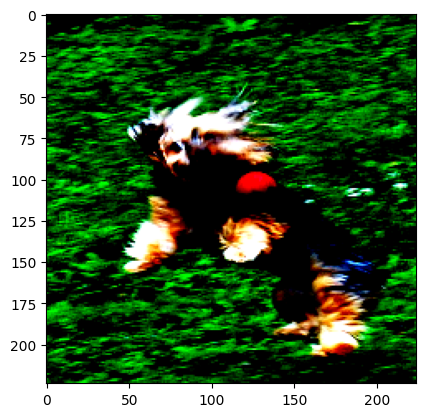

In [65]:
index = 52
image = test_dataset[index][0]
vocab = dataset.vocab

caption_greedy = greedy_generate(model, image, vocab)
print("Generated Caption (Greedy):", " ".join(caption_greedy[1:-1]))
plt.imshow(image.permute(1, 2, 0))
plt.show()